In [58]:
import numpy as np
import matplotlib.pyplot as plt

In [59]:
import pulp
#solver_list = pulp.listSolvers(onlyAvailable=True)
#print(solver_list)
#['CPLEX_PY', 'PULP_CBC_CMD']

In [60]:
length_x = 1
length_y = 1

In [61]:
x_points = np.linspace(0,length_x,100)
y_points = np.linspace(0,length_y,100)

In [62]:
x_grid, y_grid = np.meshgrid(x_points,y_points)

In [63]:
def f_func(x,y,k1,k2,length_x,length_y):
    return np.cos(k1*np.pi*x/length_x)*np.cos(k2*np.pi*y/length_y)

In [151]:
max_wave = 4
wave_numbers = [(i,j) for i in range(max_wave) for j in range(max_wave)]
wave_numbers

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [152]:
def inner_product(f1,f2):
    assert f1.shape==f2.shape
    return np.sum(f1*f2,axis=None)/(f1.size)

In [153]:
basis = {}
for k in wave_numbers:
    f_raw = f_func(x_grid,y_grid,k[0],k[1],length_x,length_y)
    h = np.sqrt(inner_product(f_raw,f_raw))
    basis[k] = f_raw/h

In [154]:
inner_product(basis[(0,1)],basis[(1,1)])

-6.217248937900877e-17

In [155]:
inner_product(basis[(1,1)],basis[(1,1)])

1.0

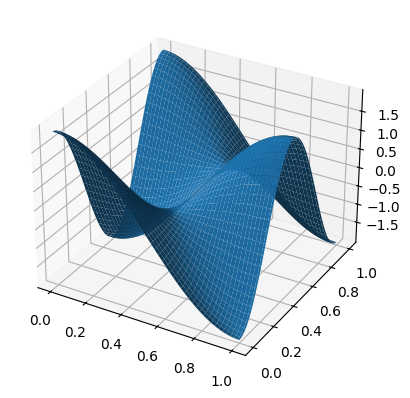

In [156]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,basis[(1,2)])

In [157]:
my_mean = np.array([0.5,0.5])
my_cov = np.array([[0.01,0],[0,0.16]])
my_inv_cov = np.linalg.inv(my_cov)
my_det_cov = np.linalg.det(my_cov)

In [158]:
my_pdf = np.zeros_like(x_grid)
for i in range(x_grid.shape[0]):
    for j in range(x_grid.shape[1]):
        xij = x_grid[i,j]
        yij = y_grid[i,j]
        vij = np.array([xij,yij])
        fij = np.exp(-0.5*np.transpose((vij-my_mean))@my_inv_cov@(vij-my_mean))/np.sqrt(4*np.pi*np.pi*my_det_cov)
        my_pdf[i,j] = fij

In [208]:
# optional overwrite with uniform
my_pdf = np.ones_like(x_grid)/(length_x*length_y)

In [209]:
# uniform in a subset
#my_pdf = (x_grid**2 + y_grid**2 >= 0.6)

In [210]:
my_pdf = my_pdf/inner_product(my_pdf,basis[(0,0)])

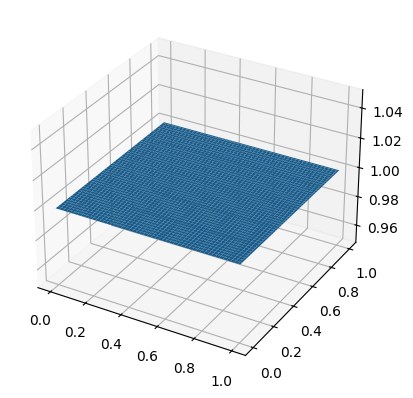

In [211]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,my_pdf)

In [212]:
eta = {}
for k in wave_numbers:
    eta[k] = inner_product(my_pdf,basis[k])

In [213]:
fourier_pdf = np.zeros_like(x_grid)
for k in wave_numbers:
    fourier_pdf += eta[k]*basis[k]

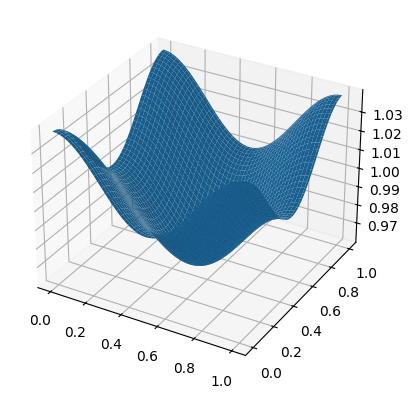

In [214]:
fig,ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_grid,y_grid,fourier_pdf)

In [215]:
wp_num_x = 8
wp_num_y = 8
x_wp,y_wp = np.meshgrid(np.linspace(0,length_x,wp_num_x),np.linspace(0,length_x,wp_num_y))

In [216]:
# convert to triangular mesh
x_wp[1::2,:] = x_wp[1::2,:] + 0.5*length_x/(wp_num_x-1)
x_wp = x_wp*(wp_num_x-1)/(wp_num_x-0.5)
y_wp = y_wp*np.cos(np.pi/6.0)*(wp_num_x-1)/(wp_num_x-0.5)
y_wp = y_wp + 0.5*length_y-np.median(y_wp,axis=None)
# seems dramatically slower

In [217]:
num_wp = wp_num_x*wp_num_y

In [218]:
wp_array = np.vstack((np.reshape(x_wp,(1,x_wp.size)),np.reshape(y_wp,(1,y_wp.size))))

In [219]:
links = [(i,j) for i in range(x_wp.size) for j in range(x_wp.size) if i!=j and np.linalg.norm(wp_array[:,i] - wp_array[:,j])<=1.1*length_x/(wp_num_x-1)]
print(f'There are {len(links)} links')

There are 322 links


(-0.05, 1.05, 0.055440292723988135, 0.9445597072760119)

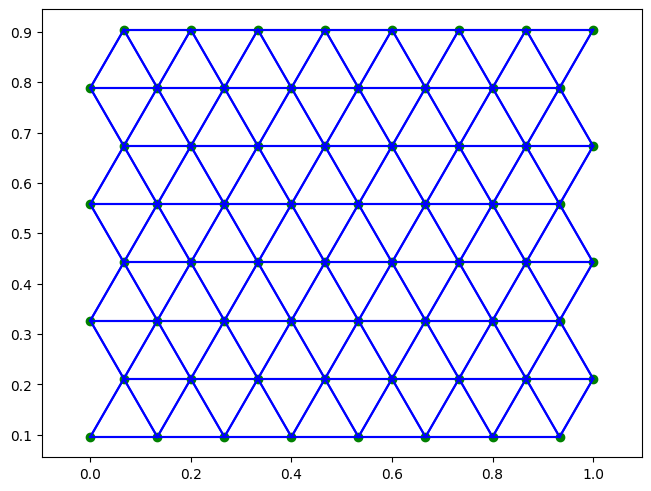

In [220]:
fig,ax = plt.subplots(layout='constrained')
ax.plot(x_wp,y_wp,'go')
for (i,j) in links:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'b-')
ax.axis('equal')

In [221]:
prob = pulp.LpProblem('ergo2')

In [222]:
num_moves = wp_num_x + wp_num_y
print(num_moves)

16


In [223]:
x = pulp.LpVariable.dicts("x",[(i,j,t) for (i,j) in links for t in range(num_moves)],0,1,pulp.LpInteger)
print(f'There are {len(x)} binary x variables')

There are 5152 binary x variables


In [224]:
# one move at a time
for t in range(num_moves):
    prob.addConstraint(sum([x[i,j,t] for (i,j) in links]) == 1)

In [225]:
# must depart from wherever we arrive
for t in range(1,num_moves):
    for w in range(num_wp):
        prob.addConstraint(sum([x[i,j,t-1] for (i,j) in links if j==w]) == sum([x[i,j,t] for (i,j) in links if i==w]))

In [226]:
# can't go straight back
#for t in range(1,num_moves):
#    for (i,j) in links:
#        if (j,i) in links:
#            prob.addConstraint(x[i,j,t-1] + x[j,i,t] <= 1)
# 6.34s without
# 44.16s with - but prettier picture

In [227]:
# always go to "higher" node at first move (symmetry of reversal)
#for (i,j) in links:
#    if j>i:
#        prob.addConstraint(x[i,j,0]==0)
# 3.06 if applied, 2.56 is not - doesn't help

In [228]:
f_traj = {}
for (i,j) in links:
    if i!=-1 and j!=-1:
        sample_point = 0.5*(wp_array[:,j] + wp_array[:,i])
        for k in wave_numbers:
            f_traj[(i,j,k)] = f_func(sample_point[0],sample_point[1],k[0],k[1],length_x,length_y)

In [229]:
s = pulp.LpVariable.dicts("s",wave_numbers,0,1,pulp.LpContinuous)

In [230]:
for k in wave_numbers:
    prob.addConstraint(s[k] >= (eta[k] - sum([f_traj[i,j,k]*x[i,j,t] for (i,j) in links for t in range(1,num_moves)])/num_moves))
    prob.addConstraint(s[k] >= -(eta[k] - sum([f_traj[i,j,k]*x[i,j,t] for (i,j) in links for t in range(1,num_moves)])/num_moves))

In [231]:
lam = {}
for k in wave_numbers:
    lam[k] = 1/(1+k[0]*k[0] + k[1]*k[1])**(3/2)

In [232]:
prob.setObjective(sum([lam[k]*s[k] for k in wave_numbers]))

In [236]:
#prob.solve()
prob.solve(solver=pulp.CPLEX_PY(timeLimit=300))
print(pulp.LpStatus[prob.status])

Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 2 times.
MIP Presolve eliminated 3 rows and 259 columns.
MIP Presolve modified 182652 coefficients.
Aggregator did 64 substitutions.
Reduced MIP has 941 rows, 4845 columns, and 123012 nonzeros.
Reduced MIP has 4830 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.66 sec. (1962.31 ticks)
Found incumbent of value 0.436045 after 0.77 sec. (2074.14 ticks)
Probing time = 0.05 sec. (19.81 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 941 rows, 4845 columns, and 123012 nonzeros.
Reduced MIP has 4830 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.08 sec. (53.82 ticks)
Probing time = 0.03 sec. (19.40 ticks)
Clique table members: 64001.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 1

In [234]:
moves = [(i,j) for t in range(num_moves) for (i,j) in links if x[i,j,t].value() >=0.5 ]
moves

[(14, 15),
 (15, 14),
 (14, 13),
 (13, 12),
 (12, 11),
 (11, 10),
 (10, 18),
 (18, 25),
 (25, 34),
 (34, 41),
 (41, 50),
 (50, 51),
 (51, 52),
 (52, 53),
 (53, 54),
 (54, 55)]

(0.0, 1.0, 0.0, 1.0)

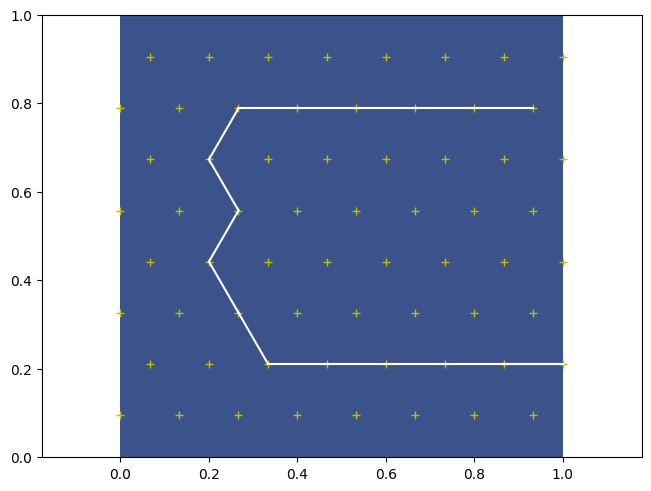

In [235]:
fig,ax = plt.subplots(layout='constrained')
ax.contourf(x_grid,y_grid,my_pdf)
ax.plot(x_wp,y_wp,'y+')
for (i,j) in moves:
    if i!=-1 and j!=-1:
        plt.plot(wp_array[0,[i,j]],wp_array[1,[i,j]],'w-')
ax.axis('equal')